<a href="https://colab.research.google.com/github/skasana/House-Prices---Advanced-Regression-Techniques/blob/main/house_price_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
print(train.shape)
train.describe()
train=train[0:5000]

(1460, 81)


In [3]:
def compare_columns(df1, df2):
    df1_columns_set = set(df1.columns)
    df2_columns_set = set(df2.columns)
    print('df1_columns_set - df2_columns_set :', df1_columns_set - df2_columns_set)
    print('df2_columns_set - df1_columns_set :', df2_columns_set - df1_columns_set)

In [4]:
train["LogSalePrice"] = train['SalePrice'].apply(np.log)

In [5]:
# determine the threshold for missing values
def calc_percent_missing(df):
    nan_percent = {col : df[col].isnull().mean() for col in df.columns}
    return nan_percent

In [6]:
nan_percent = calc_percent_missing(train)
nan_percent = pd.DataFrame(sorted(nan_percent.items(), key=lambda x: x[1], reverse=True))
nan_percent = nan_percent[nan_percent[1] >= 0.005]

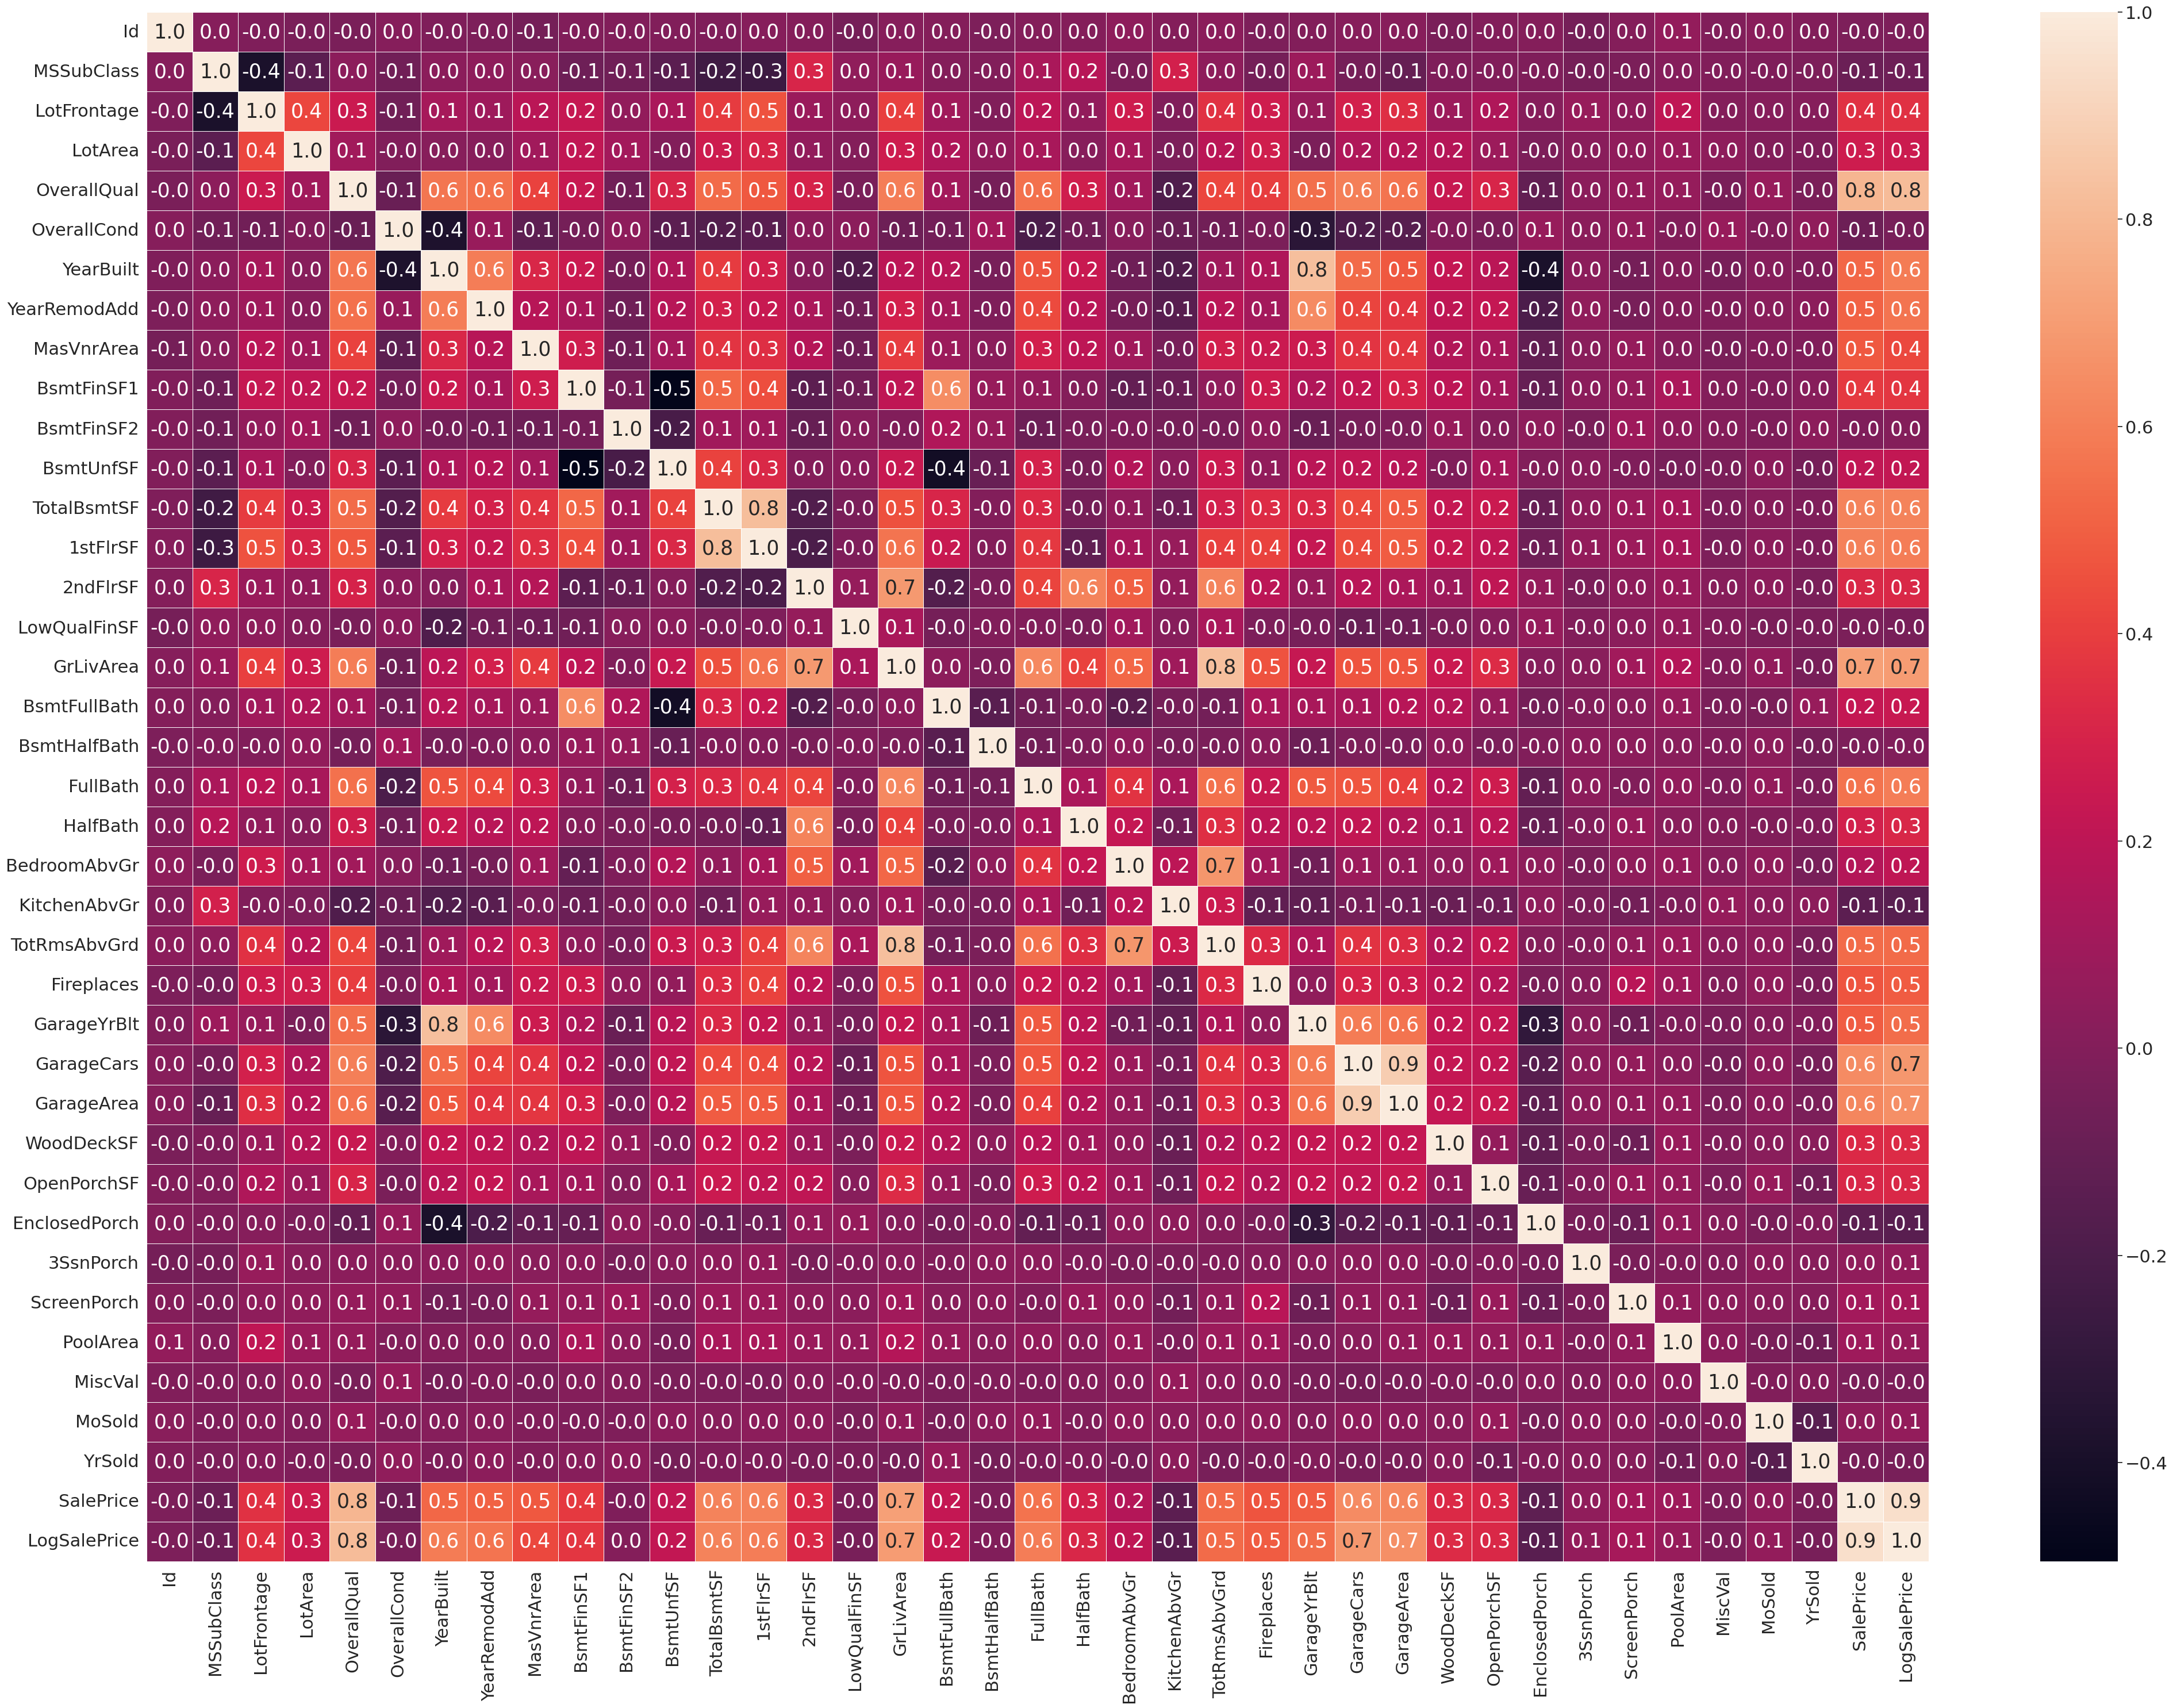

In [7]:
correlation_train=train[train.dtypes[train.dtypes != 'object'].index].corr()
sns.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sns.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f', linewidths=.5)

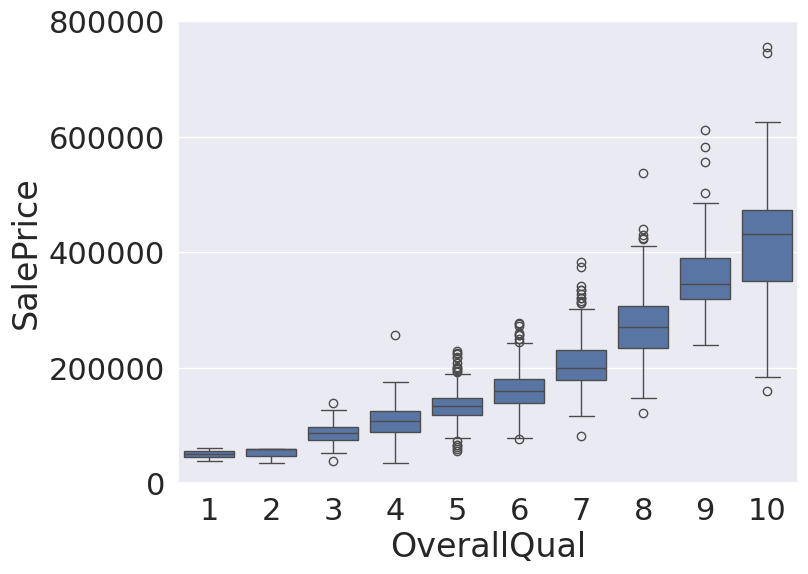

In [8]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [9]:
num_cols = [col for col in train.columns if train[col].dtype in ["float16","float32","float64", "int64", "int32"]]
cat_cols = [col for col in train.columns if train[col].dtype not in ["float16","float32","float64", "int64", "int32"]]

In [10]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479


In [11]:
df_train = train.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df_test = test.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

In [12]:
# Checking the features with NaN remained out
def replace_nan_values(df):
    for col in df:
        df[col] = df[col].fillna(df[col].mode()[0])

In [13]:
replace_nan_values(df_train)

In [14]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Id,0,0.0
GarageCars,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0


In [15]:
compare_columns(df_train,df_test)

df1_columns_set - df2_columns_set : {'LogSalePrice', 'SalePrice'}
df2_columns_set - df1_columns_set : set()


In [16]:
data = df_train.drop(columns=['SalePrice', 'LogSalePrice'])

In [17]:
compare_columns(data,df_test)

df1_columns_set - df2_columns_set : set()
df2_columns_set - df1_columns_set : set()


In [18]:
data_train_test = pd.concat([data, df_test])

In [19]:
data_train_test["SqFtPerRoom"] = data_train_test["GrLivArea"] / (data_train_test["TotRmsAbvGrd"] + data_train_test["FullBath"] + data_train_test["HalfBath"] + data_train_test["KitchenAbvGr"])
data_train_test['Total_Home_Quality'] = data_train_test['OverallQual'] + data_train_test['OverallCond']
data_train_test['Total_Bathrooms'] = data_train_test['FullBath'] + 0.5 * data_train_test['HalfBath'] + data_train_test['BsmtFullBath'] + 0.5 * data_train_test['BsmtHalfBath']
data_train_test["HighQualSF"] = data_train_test["1stFlrSF"] + data_train_test["2ndFlrSF"]

In [20]:
# Creating dummy variables from categorical features
data_train_test = pd.get_dummies(data_train_test)

In [21]:
data, df_test = data_train_test[:len(data)], data_train_test[len(data):]

In [22]:
target = df_train['LogSalePrice']
test_id = df_test['Id']

In [23]:
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

# 5 Fold Cross validation
kf = KFold(n_splits=5, shuffle=True)
cv_scores, cv_std = [], []

In [24]:
# Creation of the RMSE metric:
def rmse(model):
    return np.sqrt(-cross_val_score(model, data, target, scoring="neg_mean_squared_error", cv=kf))

In [25]:
def apply_learning_algorithm(model):
    score = rmse(model)
    cv_scores.append(score.mean())
    cv_std.append(score.std())

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [27]:
model = LinearRegression()

In [28]:
x_train, x_validation, y_train, y_validation = train_test_split(data, target, test_size = 0.1)

In [29]:
model.fit(x_train,y_train)

LinearRegression()

In [30]:
preds = model.predict(x_validation)

In [31]:
mean_squared_error(y_validation,preds)

0.010518809364550904

In [32]:
test_pred = model.predict(df_test)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred
submission.head()
submission.to_csv("submission.csv", index = False, header = True)